In [1]:
import tensorflow as tf

# Create TensorFlow object called tensor
hello_constant = tf.constant('Hello World!')

with tf.Session() as sess:
    # Run the tf.constant operation in the session
    output = sess.run(hello_constant)
    print(output)

b'Hello World!'


# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [2]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
#importing some useful packages
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import timeit
import cv2
import os
%matplotlib inline

In [3]:
# Load pickled data
import pickle


# TODO: fill this in based on where you saved the training and testing data
training_file ='train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(len(np.unique(y_train)))


43


In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape =X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

n_input = np.prod(X_train[0].shape)
learning_rate = 0.01
batch_size = 128
training_epochs = 30

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


def one_hot_encode(y, num_examples, num_classes):
    ret_y = np.zeros((num_examples, num_classes))
    for r in range(num_examples):
        ret_y[r][y[r]] = 1
    return ret_y

encoded_train_labels=one_hot_encode(y_train,len(y_train),n_classes)
encoded_test_labels=one_hot_encode(y_test,len(y_test),n_classes)
"""
a=np.random.randint(30000, size=1)
print(encoded_train_labels[a,y_train[a]])
print(a)
"""


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


'\na=np.random.randint(30000, size=1)\nprint(encoded_train_labels[a,y_train[a]])\nprint(a)\n'

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1
_Describe the techniques used to preprocess the data._


**Answer:**
Images are converted to gray scale and then normalized by subtracting a mean image 

In [5]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
class ttime:
    def __init__(self):
        self.start=[]
        self.stop=[]
        self.epoch_start=[]
        self.epoch_stop=[]
    def total_time_start(self):        
        self.start = timeit.default_timer()        
    def total_time_stop(self):                
        self.stop = timeit.default_timer()
        print((self.stop - self.start )/60)
    def epoch_time_start(self):
        self.epoch_start = timeit.default_timer()
    def epoch_time_stop(self):                
        self.epoch_stop = timeit.default_timer()        
        print((self.epoch_stop - self.epoch_start )/60)
    


class data:
    
    def __init__(self,X_train,y_train,X_test,y_test):
        self.color_training_data=X_train
        self.training_data=np.empty([X_train.shape[0],X_train.shape[1],X_train.shape[2],1])
        
        self.labels_training_data=y_train
        
        self.color_testing_data=X_test
        self.testing_data=np.empty([X_test.shape[0],X_test.shape[1],X_test.shape[2],1])
        
        self.labels_testing_data=y_test        
        self.train=len(X_train)
        self.test=len(X_test)
        
        self.train_indices = np.arange(self.train)
        self.randomized_train_indices=np.arange(self.train)
        np.random.shuffle(self.randomized_train_indices)
        
        self.test_indices = np.arange(self.test)
        self.randomized_test_indices=np.arange(self.test)
        np.random.shuffle(self.randomized_test_indices)
        
    def randomize(self):
        self.randomized_training_data=self.training_data[self.randomized_train_indices]
        self.randomized_labels_training_data=self.labels_training_data[self.randomized_train_indices]    
        self.randomized_testing_data=self.testing_data[self.randomized_test_indices]
        self.randomized_labels_testing_data=self.labels_testing_data[self.randomized_test_indices]
        self.bookmark=0
        
    def preprocess_images(self):        
        
        for i in range(len(self.color_training_data)):
            self.training_data[i]=cv2.cvtColor(self.color_training_data[i], cv2.COLOR_BGR2GRAY).reshape(32,32,1)
        for i in range(len(self.color_testing_data)):
            self.testing_data[i]=cv2.cvtColor(self.color_testing_data[i], cv2.COLOR_BGR2GRAY).reshape(32,32,1)        
            
        #if 0:  
            
        #self.training_data=(self.training_data-(np.mean(self.training_data,axis=0)))/np.std(self.training_data)
        #print("shape",self.training_data[0].shape)
        #self.testing_data=(self.testing_data-(np.mean(self.testing_data)))/np.std(self.testing_data)
        #print("shape",self.testing_data[0].shape)
        
        
        
        self.training_data=(self.training_data)/255
        print("shape",self.training_data[0].shape)
        self.testing_data=self.testing_data/255
        print("shape",self.testing_data[0].shape)
            
        
    def next_batch(self,batch_size):
        if self.bookmark+batch_size<=self.train:
            batch_x=self.randomized_training_data[self.bookmark:self.bookmark+batch_size]
            batch_y=self.randomized_labels_training_data[self.bookmark:self.bookmark+batch_size]
            self.bookmark=self.bookmark+batch_size
        elif self.bookmark+batch_size>self.train & self.bookmark<=self.train:
            batch_x=self.randomized_training_data[self.bookmark:]
            batch_y=self.randomized_labels_training_data[self.bookmark:]
            self.bookmark=0
            
        return batch_x,np.array(batch_y)
    
Data=data(X_train,encoded_train_labels,X_test,encoded_test_labels)
Data.preprocess_images()
Data.randomize()
T=ttime()


############################################################
"""
print(np.sum(Data.randomized_training_data-Data.training_data[Data.randomized_train_indices]))
print(np.sum(Data.randomized_labels_training_data-Data.labels_training_data[Data.randomized_train_indices]))
print(np.sum(Data.randomized_testing_data-Data.testing_data[Data.randomized_test_indices]))
print(np.sum(Data.randomized_labels_testing_data-Data.labels_testing_data[Data.randomized_test_indices]))
print(Data.randomized_labels_training_data.shape)
print(Data.randomized_labels_testing_data.shape)
x,y=Data.next_batch(128)
x,y=Data.next_batch(128)


print(np.sum(x-Data.training_data[Data.randomized_train_indices[128:256]]))
print(np.sum(y-Data.labels_training_data[Data.randomized_train_indices[128:256]]))


"""



shape (32, 32, 1)
shape (32, 32, 1)


'\nprint(np.sum(Data.randomized_training_data-Data.training_data[Data.randomized_train_indices]))\nprint(np.sum(Data.randomized_labels_training_data-Data.labels_training_data[Data.randomized_train_indices]))\nprint(np.sum(Data.randomized_testing_data-Data.testing_data[Data.randomized_test_indices]))\nprint(np.sum(Data.randomized_labels_testing_data-Data.labels_testing_data[Data.randomized_test_indices]))\nprint(Data.randomized_labels_training_data.shape)\nprint(Data.randomized_labels_testing_data.shape)\nx,y=Data.next_batch(128)\nx,y=Data.next_batch(128)\n\n\nprint(np.sum(x-Data.training_data[Data.randomized_train_indices[128:256]]))\nprint(np.sum(y-Data.labels_training_data[Data.randomized_train_indices[128:256]]))\n\n\n'

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I have not used any validation data but randomized the order of training data to avoid gradients to move biased to a direction

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
layer_width = {
    'layer_1': 32,
    'layer_2': 64,    
    'fully_connected': 1024
    
       
}
"""

#32x32
layer1 5x5x32
32x32x32
layer2 64 5x5x32x64
32x32x64
fc 


droupout
layer3 128 5x5x64x128



fc 4x4x256x256 
256
fc 256 256x43 43

"""




weights = {
    #32x32x1 5x5x1x32 16x16x32
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5,1, layer_width['layer_1']],mean=0, stddev=0.01)),
    #16x16x32 5x5x32x64  8x8x64
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']],mean=0, stddev=0.01)),
    #8x8x64 5x5x64x128 4x4x12   
    
       
    #4x4x128 4x4x128x512 512
    'fully_connected': tf.Variable(tf.truncated_normal(
        [1600, layer_width['fully_connected']],mean=0, stddev=0.01)),
    
    #512 512x43 43
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes],mean=0, stddev=0.01))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),    
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

def conv2d(x,W,b,strides=1):
    x=tf.nn.conv2d(x,W,strides=[1,strides,strides,1],padding='VALID')
    x=tf.nn.bias_add(x,b)
    x=tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    return tf.nn.relu(x)


def conv_net(x,weights,biases):
    
    conv1=conv2d(x,weights['layer_1'],biases['layer_1'])
    conv1=tf.nn.dropout(conv1,0.9)

    


    conv2=conv2d(conv1,weights['layer_2'],biases['layer_2'])     
    conv2=tf.nn.dropout(conv2,0.9)
    


    fc1 = tf.reshape(conv2,  [-1, weights['fully_connected'].get_shape().as_list()[0]]  )
    fc1 = tf.add(  tf.matmul(fc1, weights['fully_connected']),   biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)


    out=tf.add(tf.matmul(fc1,weights['out']),biases['out'])


               
    return out
               
    
    
    

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I have used a layer of convolution,maxpool, relu activations, drop out followed by another layer of convloution,maxpool, relu activation, dropout, followed by two fully connected layers 

In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder("float", [None, 32, 32,1])
y = tf.placeholder("float", [None, n_classes])
print(x.get_shape())
print(y.get_shape())

logits = conv_net(x, weights, biases)
#print(logits.get_shape())
prob_logits=tf.nn.softmax(logits)
max_prob=tf.nn.top_k(prob_logits, k=5, sorted=True, name=None)
#print(prob_logits.get_shape())
predicted_labels=tf.argmax(prob_logits,1)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

# Test model
correct_prediction = tf.equal(predicted_labels, tf.argmax(y, 1))
correct_prediction2 = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
accuracy2 = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Initializing the variables
init = tf.initialize_all_variables()



(?, 32, 32, 1)
(?, 43)


In [9]:
learning_rate = 1e-3
training_epochs=8
T.total_time_start()

sess = tf.Session()

sess.run(init)                                                                                                                              #print(training_epochs)
for epoch in range(training_epochs):        
    T.epoch_time_start()
    total_batch = int(len(X_train)/batch_size)                                                                                                                                                #print(total_batch)        
    for i in range(total_batch):
        batch_x, batch_y = Data.next_batch(batch_size)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

    c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
    T.epoch_time_stop()

    print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    
print("Optimization Finished!")
print("overall training Accuracy:",sess.run(accuracy,{x: Data.training_data, y: Data.labels_training_data}))                                                                                                                        #print("overall training Accuracy:",accuracy2.eval({x: Data.training_data, y: Data.labels_training_data}))
print("overall training Accuracy:",sess.run(accuracy,{x: Data.testing_data, y: Data.labels_testing_data}))                                                                                                                             #print("overall testing Accuracy:", accuracy2.eval({x: Data.testing_data, y: Data.labels_testing_data}))
T.total_time_stop()

a=sess.run(prob_logits,feed_dict={x:Data.testing_data,y:Data.labels_testing_data})
top_5_pred = sess.run(max_prob, feed_dict={x:Data.testing_data,y:Data.labels_testing_data})
    

    
    

0.8129050808666458
Epoch: 0001 cost= 0.502177775
0.8172959557166298
Epoch: 0002 cost= 0.171438247
0.8273223917166737
Epoch: 0003 cost= 0.105759598
0.8266739217166711
Epoch: 0004 cost= 0.031744238
0.8262440278499829
Epoch: 0005 cost= 0.023722611
0.8272263760666344
Epoch: 0006 cost= 0.070290193
0.829210188216651
Epoch: 0007 cost= 0.008130743
0.8272995292666262
Epoch: 0008 cost= 0.023247357
Optimization Finished!
overall training Accuracy: 0.993471
overall training Accuracy: 0.921299
6.90656007334995


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I have trained for 10 epochs with a batch size of 128 and used Adam optimizer as gradient descnet weight updates may not be the optimal direction for cost minimization and takes so long to converge

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I initially used Gradient descent which took so many epochs and the cost was not minimized then increased the learning rate which stopped cost minimization after few epochs. I then used adam optimizer with low learning rate which gave me good accuracies in 10 epochs. Realizing that testing accuracy is lower comapred to training accuracy ,I have increased drop out probabilty which increased testing accuarcy


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

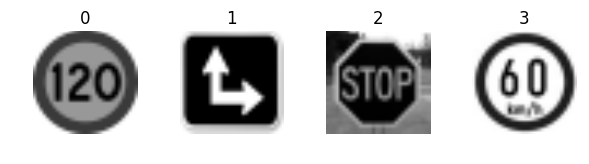

In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
sample_train_images=np.zeros((16,32,32,3))
   
import os
files=os.listdir("tes/")
Images = np.zeros(shape=(len(files),32,32), dtype="float32")
color_Images = np.zeros(shape=(len(files),32,32,3), dtype="float32")

i=0

for file in files:    
      
    img = mpimg.imread('tes/'+file)    
    img=cv2.resize(img,(32,32),interpolation = cv2.INTER_AREA)           
    
    color_Images[i]=img
    
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    Images[i]=img
    
    i+=1    
   

figures={i: Images[i] for i in range(len(Images))}


plot_figures(figures, 1, 4)      



true_labels=[8 ,36 ,14, 3]


j=0


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** Zoomed traffic signs might be little difficult for classification

In [13]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
Images=Images.reshape((len(files),32,32,1))
Images=Images/255
labels=sess.run(predicted_labels,feed_dict={x: Images})
print(labels)
print(true_labels)


[ 3  3 14 38]
[8, 36, 14, 3]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
No it did not perform well on some images

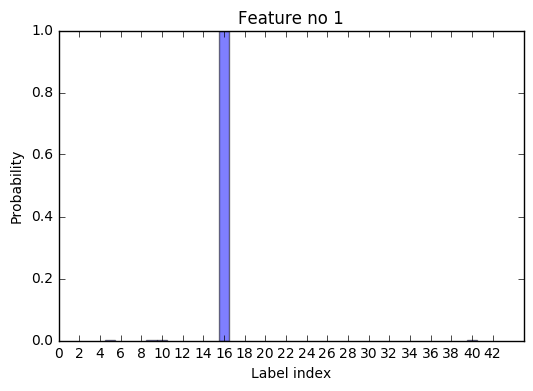

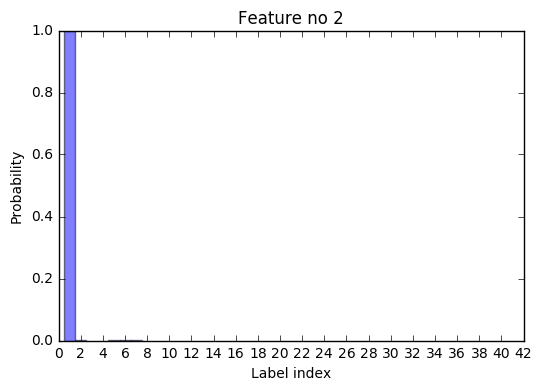

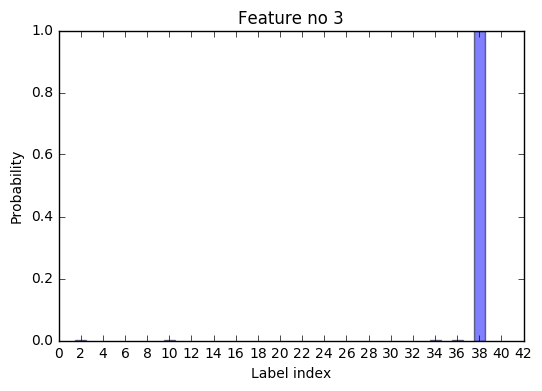

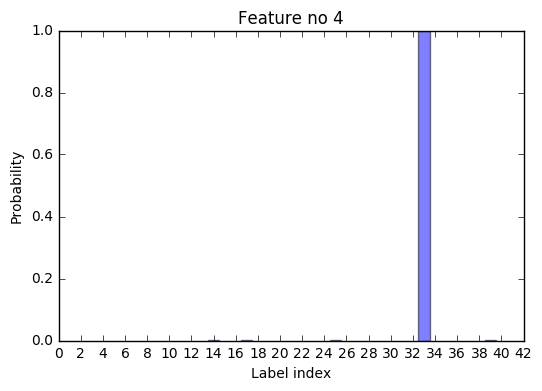

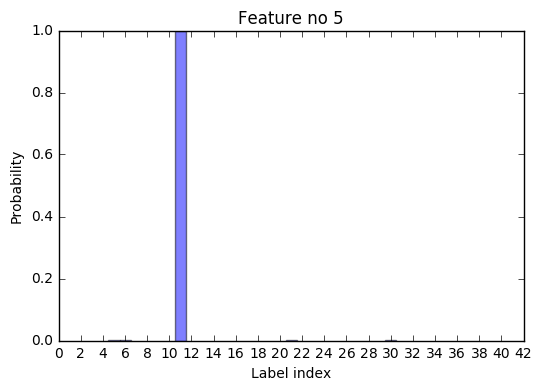

In [14]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

for i in range(5):    
    plt.bar(top_5_pred[1][i], top_5_pred[0][i], align="center", alpha=0.5, width = 1)
    plt.xticks(np.arange(0,44,2))
    plt.title("Feature no %d" %(i+1))
    plt.ylabel("Probability")
    plt.xlabel("Label index")
    plt.show()



### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** The model was certain of all the predictions and correct prediction appears 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.